In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import egg.core as core
from options import Options
opts = Options()

from typing import Any, List, Optional, Sequence, Union

import torch.utils.data
from torch_geometric.data import Batch, Dataset, Data
from torch_geometric.data.data import BaseData
from torch_geometric.data.datapipes import DatasetAdapter
from torch_geometric.data.on_disk_dataset import OnDiskDataset

In [23]:
import os
import torch
import random
from torch_geometric.data import Dataset
from graph.build import create_family_tree, create_data_object

class FamilyGraphDataset(Dataset):
    """
    Dataset class for generating family graph data.

    Args:
        root (str): Root directory path.
        number_of_graphs (int): Number of graphs to generate.
        generations (int): Number of generations in each family tree.

    Returns:
        Data(x=[8, 2], edge_index=[2, 20], edge_attr=[20], labels=[8])
    """
    def __init__(self, root, number_of_graphs, generations, transform=None, pre_transform=None):
        self.number_of_graphs = number_of_graphs
        self.generations = generations
        super(FamilyGraphDataset, self).__init__(root, transform, pre_transform)
        self.data = None
        self.process()

    @property
    def processed_file_names(self):
        return ['family_graphs.pt']

    def len(self):
        return len(self.data)

    def get(self, idx):
        return self.data[idx]
    
    def generate_labels(self, num_nodes):
        target_node_idx = random.randint(0, num_nodes - 1)
        return target_node_idx
    
    def generate_root(self, num_nodes, target_node_idx):
        node_indices = list(range(num_nodes))
        node_indices.remove(target_node_idx)
        root_idx = random.choice(node_indices)
        return root_idx
    
    def process(self):
        if not os.path.isfile(self.processed_paths[0]):
            self.data = []
            for _ in range(self.number_of_graphs):
                family_tree = create_family_tree(self.generations)
                graph_data = create_data_object(family_tree)

                # Generate random labels for each node
                target_node_idx = self.generate_labels(graph_data.num_nodes)

                # Store the labels as an attribute of the graph_data
                graph_data.target_node_idx = target_node_idx

                root_idx = self.generate_root(graph_data.num_nodes, target_node_idx)

                graph_data.root_idx = root_idx

                self.data.append(graph_data)

            torch.save(self.data, self.processed_paths[0])
        else:
            self.data = torch.load(self.processed_paths[0])

In [27]:
dataset = FamilyGraphDataset(root='/Users/meeslindeman/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Code/data', number_of_graphs=100, generations=2)
print(dataset[0])
print(dataset[1])

Data(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=0, root_idx=3)
Data(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=3, root_idx=0)


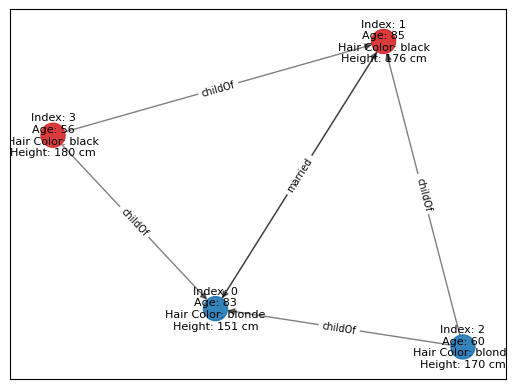

In [26]:
from graph.draw import draw_graph

plot = draw_graph(dataset[1])

In [28]:
total_nodes = 0
for i in range(0, len(dataset)):
    total_nodes += dataset[i].x.shape[0]  # shape[0] gives the number of nodes in each graph

average_nodes = total_nodes / len(dataset)
print("Average number of nodes:", average_nodes)

Average number of nodes: 4.0


In [29]:
graph = dataset[0]
print(*graph, sep="\n")

('x', tensor([[  0.,  87.,   3., 183.],
        [  1.,  92.,   3., 158.],
        [  0.,  60.,   3., 160.],
        [  0.,  63.,   0., 176.]]))
('edge_index', tensor([[0, 1, 2, 3, 1, 0, 2, 3],
        [1, 0, 0, 0, 0, 1, 1, 1]]))
('edge_attr', tensor([0., 0., 1., 1., 0., 0., 1., 1.]))
('target_node_idx', 0)
('root_idx', 3)


In [30]:
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, embedding_size, heads):
        super().__init__()
        self.conv1 = GATv2Conv(num_node_features, embedding_size, edge_dim=1, heads=heads, concat=True)
        self.conv2 = GATv2Conv(-1, embedding_size, edge_dim=1, heads=heads, concat=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        h = self.conv2(x=h, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        return h
    
from torch_geometric.nn import TransformerConv

class Transform(torch.nn.Module):
    def __init__(self, num_node_features, embedding_size, heads):
        super().__init__()
        self.conv1 = TransformerConv(num_node_features, embedding_size, edge_dim=0, heads=heads, concat=True)
        self.conv2 = TransformerConv(-1, embedding_size, edge_dim=0, heads=heads, concat=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        h = self.conv2(x=h, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        return h

In [10]:
class SenderDual(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderDual, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h_t = self.transform(data)

        h_g = self.gat(data)

        # h = h_t + h_g

        h = torch.cat((h_t, h_g), dim=0)

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverDual(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverDual, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h_t = self.transform(data)

        h_g = self.gat(data)

        # h = h_t + h_g   

        h = torch.cat((h_t, h_g), dim=0)

        message_embedding = self.fc(message)        

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

In [9]:
class SenderGAT(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderGAT, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h = self.gat(data)

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverGAT(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverGAT, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size

        self.gat = GAT(self.num_node_features, embedding_size, heads)
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h = self.gat(data)   

        message_embedding = self.fc(message)                 

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

In [10]:
class SenderTransform(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderTransform, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature
          
        self.transform = Transform(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h = self.transform(data)

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverTransform(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverTransform, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        
        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h = self.transform(data)   

        message_embedding = self.fc(message)                 

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

NOTES:

- Transformer works for graphs with same amount of nodes, also works on one instance with different size notes but gets stuck in wrapper because size keeps changing. It takes the first input as weigth dimension.
- Dual doesn't get passed .55 even though transformer only yeilds high accuracy on two nodes.

## Ouput for a single graph

In [11]:
agents = "dual"

In [12]:
if agents == "dual":
    sender = SenderDual(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverDual(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size)
elif agents == "transform":
    sender = SenderTransform(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverTransform(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size) 
elif agents == "gat":
    sender = SenderGAT(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverGAT(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size) 
else:
    print("Invalid agent type")

In [13]:
graph = dataset[0]
print(graph)

# Sender produces a message
sender_output = sender(None, graph)
print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, graph)
print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)

Data(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=3)
Sender's message: tensor([[ 7.8803e-03,  1.0646e+01,  1.3122e+01,  3.2931e+00, -9.0272e+00,
         -2.8195e+00,  3.2786e-02,  4.0129e+00,  7.7648e+00, -4.0562e+00,
         -1.0264e+01, -2.9099e+00, -1.3866e+01, -5.1923e+00,  3.2604e+00,
          2.4008e+00,  3.9455e+00, -3.8855e+00,  4.7210e+00,  6.2439e+00]],
       grad_fn=<ViewBackward0>)
Sender's shape:  torch.Size([1, 20])
Receiver's output: tensor([[-1.6497e-04, -8.7100e+00, -1.2018e+02, -1.5390e+02, -5.4423e+02,
         -5.4285e+02, -6.2716e+02, -5.4625e+02]],
       grad_fn=<LogSoftmaxBackward0>)
Receiver's shape:  torch.Size([1, 8])


In [137]:
sender_gs = core.RnnSenderGS(sender, opts.vocab_size, opts.embedding_size, opts.hidden_size, max_len=opts.max_len, temperature=opts.gs_tau, cell=opts.sender_cell)
receiver_gs = core.RnnReceiverGS(receiver, opts.vocab_size, opts.embedding_size, opts.hidden_size, cell=opts.sender_cell)

# Sender produces a message
sender_output = sender_gs(None, graph)
print("Sender's message:", sender_output)
print("Sender's shape:", sender_output.shape) # batch size x max_len+1 x vocab size

# Receiver tries to identify the target node
receiver_output = receiver_gs(sender_output, None, graph)
#print("Receiver's output:", receiver_output)
print("Receiver's shape:", receiver_output.shape) # nodes x max_len+1 x num_classes (nodes)

Sender's message: tensor([[[1.2995e-28, 1.0393e-07, 4.5792e-30, 6.2971e-15, 9.8723e-17,
          6.7808e-21, 2.9953e-19, 5.8745e-21, 7.3455e-13, 9.4506e-19,
          8.6804e-29, 1.3020e-08, 2.0840e-24, 5.9708e-08, 5.2845e-29,
          2.4458e-08, 1.5149e-18, 2.9008e-10, 5.1913e-22, 1.7459e-14,
          1.1257e-13, 2.9473e-09, 1.4371e-24, 3.8744e-22, 2.3324e-11,
          1.6934e-14, 5.4362e-14, 8.7615e-13, 1.3473e-14, 1.3434e-11,
          1.7999e-25, 9.4566e-01, 2.8888e-20, 4.0789e-16, 6.1162e-17,
          1.2707e-07, 4.4792e-20, 4.6772e-22, 1.6650e-17, 1.1060e-14,
          3.1547e-24, 9.6460e-11, 9.5454e-09, 2.2582e-17, 4.4365e-11,
          7.3510e-14, 3.1243e-06, 1.8745e-17, 2.7937e-14, 6.4621e-12,
          1.4592e-15, 7.7332e-28, 3.5923e-23, 2.1970e-21, 3.6789e-09,
          1.6072e-20, 1.0490e-27, 1.5521e-16, 5.3766e-10, 2.2633e-17,
          8.4482e-07, 2.7245e-27, 7.9548e-20, 1.7344e-19, 2.7697e-19,
          3.0307e-21, 1.5484e-14, 7.4088e-14, 1.0469e-17, 1.8316e-20,
  

In [111]:
def loss_nll(
    _sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    NLL loss - differentiable and can be used with both GS and Reinforce
    """
    labels = torch.tensor([labels]).long()
    nll = F.nll_loss(receiver_output, labels, reduction="none")
    acc = (labels == receiver_output.argmax(dim=1)).float().mean()
    return nll, {"acc": acc}

game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

loss, interaction = game(sender_input=None, labels=graph.target_node_idx, receiver_input=None, aux_input=graph)
print(loss)
print("====================================")
#print(interaction)

tensor(963.9621, grad_fn=<MeanBackward0>)


## Batching

In [112]:
class Collater:
    def __init__(
        self,
        game_size: int,  # the number of graphs for a game
        dataset: Union[Dataset, Sequence[BaseData], DatasetAdapter],
        follow_batch: Optional[List[str]] = None,
        exclude_keys: Optional[List[str]] = None,
    ):
        self.game_size = game_size
        self.dataset = dataset
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys

    def __call__(self, batch: List[Any]) -> Any:
        elem = batch[0]
        if isinstance(elem, BaseData):
            batch = batch[:((len(batch) // self.game_size) * self.game_size)]  # we throw away the last batch_size % game_size
            batch = Batch.from_data_list(
                batch,
                follow_batch=self.follow_batch,
                exclude_keys=self.exclude_keys,
            )
            # we return a tuple (sender_input, labels, receiver_input, aux_input)
            # we use aux_input to store minibatch of graphs
            return (
                torch.zeros(len(batch) // self.game_size, 1),  # we don't need sender_input --> create a fake one
                batch.target_node_idx,  # the target is aways the first graph among game_size graphs
                None,  # we don't care about receiver_input
                batch  # this is a compact data for batch_size graphs 
            )

        raise TypeError(f"DataLoader found invalid type: '{type(elem)}'")

    def collate_fn(self, batch: List[Any]) -> Any:
        if isinstance(self.dataset, OnDiskDataset):
            return self(self.dataset.multi_get(batch))
        return self(batch)


class DataLoader(torch.utils.data.DataLoader):
    def __init__(
        self,
        game_size: int,  # the number of graphs for a game
        dataset: Union[Dataset, Sequence[BaseData], DatasetAdapter],
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: Optional[List[str]] = None,
        exclude_keys: Optional[List[str]] = None,
        **kwargs,
    ):
        self.game_size = game_size
        # Remove for PyTorch Lightning:
        kwargs.pop('collate_fn', None)

        # Save for PyTorch Lightning < 1.6:
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys

        self.collator = Collater(game_size, dataset, follow_batch, exclude_keys)

        if isinstance(dataset, OnDiskDataset):
            dataset = range(len(dataset))

        super().__init__(
            dataset,
            batch_size,
            shuffle,
            collate_fn=self.collator.collate_fn,
            **kwargs,
        )

In [113]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Print the lengths of the training and validation sets
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))

Training set length: 80
Validation set length: 20


In [114]:
train_loader = DataLoader(game_size=1, dataset=train_data, batch_size=opts.batch_size, shuffle=True)
val_loader = DataLoader(game_size=1, dataset=val_data, batch_size=opts.batch_size, shuffle=True)

## Outputs for batch

In [115]:
batch = next(iter(train_loader))
print(batch[3])

DataBatch(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=[1], root_idx=[1], batch=[4], ptr=[2])


In [138]:
print(batch[3])

# Sender produces a message
sender_output = sender(None, batch[3])
#print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, batch[3])
#print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)

DataBatch(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=[1], root_idx=[1], batch=[4], ptr=[2])
Sender's shape:  torch.Size([1, 20])
Receiver's shape:  torch.Size([1, 4])


In [139]:
# Sender produces a message
sender_output = sender_gs(None, batch[3])
#print("Sender's message:", sender_output)
print("Sender's shape:", sender_output.shape) # batch size x max_len+1 x vocab size

# Receiver tries to identify the target node
receiver_output = receiver_gs(sender_output, None, batch[3])
#print("Receiver's output:", receiver_output)
print("Receiver's output shape:", receiver_output.shape)

Sender's shape: torch.Size([1, 5, 100])
Receiver's output shape: torch.Size([1, 5, 4])


In [140]:
def loss_nll(
    _sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    NLL loss - differentiable and can be used with both GS and Reinforce
    """
    nll = F.nll_loss(receiver_output, labels, reduction="none")
    acc = (labels == receiver_output.argmax(dim=1)).float().mean()
    return nll, {"acc": acc}

game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

loss, interaction = game(*batch)
print(loss)
print("====================================")
#print(interaction)

tensor(328.8167, grad_fn=<MeanBackward0>)


In [141]:
game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

options = core.init(params=['--random_seed=7', 
                         '--lr=1e-2',   
                         f'--batch_size={opts.batch_size}',
                         '--optimizer=adam',
                         '--update_freq=10'])

optimizer = torch.optim.Adam(game.parameters())

trainer = core.Trainer(
    game=game, 
    optimizer=optimizer, 
    train_data=train_loader,
    validation_data=val_loader, 
    callbacks=[core.ConsoleLogger(as_json=True, print_train_loss=True)]
)

trainer.train(n_epochs=50)

{"loss": 36.91419219970703, "acc": 0.15000000596046448, "length": 5.0, "mode": "train", "epoch": 1}
{"loss": 136.19921875, "acc": 0.10000000149011612, "length": 5.0, "mode": "test", "epoch": 1}
{"loss": 6.097718715667725, "acc": 0.16249999403953552, "length": 5.0, "mode": "train", "epoch": 2}
{"loss": 56.4969367980957, "acc": 0.4000000059604645, "length": 5.0, "mode": "test", "epoch": 2}
{"loss": 5.2301411628723145, "acc": 0.2874999940395355, "length": 5.0, "mode": "train", "epoch": 3}
{"loss": 36.75326156616211, "acc": 0.25, "length": 5.0, "mode": "test", "epoch": 3}
{"loss": 3.3263461589813232, "acc": 0.4124999940395355, "length": 5.0, "mode": "train", "epoch": 4}
{"loss": 26.050853729248047, "acc": 0.3499999940395355, "length": 5.0, "mode": "test", "epoch": 4}
{"loss": 1.8033307790756226, "acc": 0.4124999940395355, "length": 5.0, "mode": "train", "epoch": 5}
{"loss": 14.786863327026367, "acc": 0.30000001192092896, "length": 5.0, "mode": "test", "epoch": 5}
{"loss": 1.437232017517089

In [24]:
from analysis.logger import ResultsCollector

def perform_training(opts: Options, train_loader, val_loader, game):
    results = []

    options = core.init(params=['--random_seed=7', 
                            '--lr=1e-2',  
                            f'--batch_size={opts.batch_size}',
                            '--optimizer=adam',
                            '--update_freq=10'])

    optimizer = torch.optim.Adam(game.parameters())

    trainer = core.Trainer(
        game=game, 
        optimizer=optimizer, 
        train_data=train_loader,
        validation_data=val_loader, 
        # callbacks=[core.ConsoleLogger(as_json=True, print_train_loss=True)]
        callbacks=[ResultsCollector(results, print_to_console=True)]
    )

    trainer.train(n_epochs=50)
    core.close()
    
    return '\n'.join(results), trainer

results, trainer = perform_training(opts, train_loader, val_loader, game)

train: epoch 1, loss 1.1935118436813354, acc=0.08749999850988388, epoch=1, length=4.999988555908203, loss=1.1935118436813354, mode=train
test: epoch 1, loss 9.766031265258789, acc=0.05000000074505806, epoch=1, length=5.0, loss=9.766031265258789, mode=test
train: epoch 2, loss 0.6302833557128906, acc=0.13750000298023224, epoch=2, length=5.0, loss=0.6302833557128906, mode=train
test: epoch 2, loss 3.595853805541992, acc=0.20000000298023224, epoch=2, length=5.0, loss=3.595853805541992, mode=test
train: epoch 3, loss 0.28800681233406067, acc=0.17499999701976776, epoch=3, length=5.0, loss=0.28800681233406067, mode=train
test: epoch 3, loss 2.785019636154175, acc=0.4000000059604645, epoch=3, length=5.0, loss=2.785019636154175, mode=test
train: epoch 4, loss 0.2600439190864563, acc=0.16249999403953552, epoch=4, length=5.0, loss=0.2600439190864563, mode=train
test: epoch 4, loss 2.8762357234954834, acc=0.20000000298023224, epoch=4, length=5.0, loss=2.8762357234954834, mode=test
train: epoch 5,

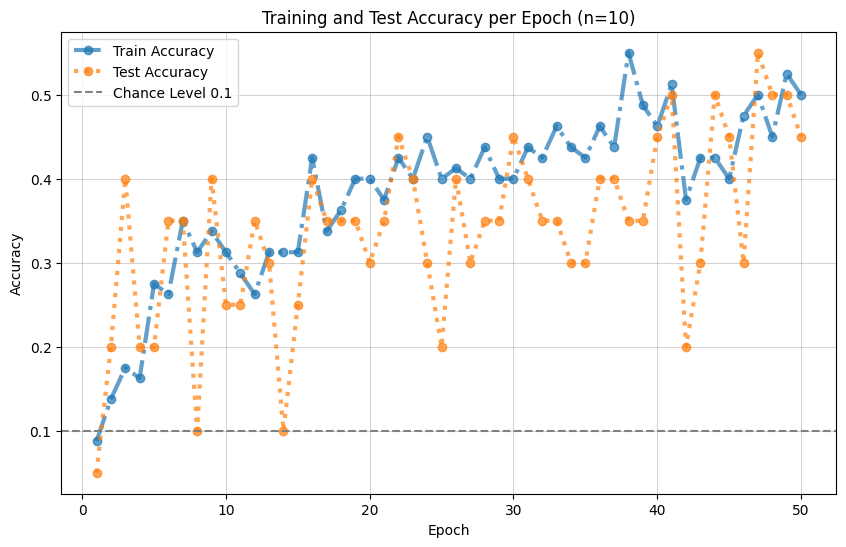

In [25]:
from analysis.plot import plot_acc

plot_acc(results, dataset[0].num_nodes)

## Analysis

In [26]:
loss, interaction = game(*batch)
print(loss)
print("====================================")
print(interaction)

tensor(1.0616, grad_fn=<MeanBackward0>)
Interaction(sender_input=tensor([[0.]]), receiver_input=None, labels=tensor([1]), aux_input=DataBatch(x=[10, 4], edge_index=[2, 24], edge_attr=[24], target_node_idx=[1], batch=[10], ptr=[2]), message=tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [27]:
# Look at early stopping for acc=1.0

import pathlib
import torch

class EarlyStopperWithInteractionSaving(core.EarlyStopperAccuracy):
    def __init__(
        self, 
        threshold: float, 
        field_name: str = "acc", 
        validation: bool = True, 
        save_dir: str = "./saved_interactions",
        save_rank: int = 0
    ):
        super().__init__(threshold, field_name, validation)
        self.save_dir = pathlib.Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.save_rank = save_rank

    def on_validation_end(self, loss: float, logs: core.Interaction, epoch: int) -> None:
        super().on_validation_end(loss, logs, epoch)
        if self.trainer.distributed_context.rank == self.save_rank:
            metric_mean = logs.aux[self.field_name].mean()
            if metric_mean >= self.threshold:
                self.save_interaction(logs, epoch)

    def save_interaction(self, interaction: core.Interaction, epoch: int):
        file_path = self.save_dir / f"interaction_epoch_{epoch}.pt"
        torch.save(interaction, file_path)

# Example usage
# early_stopper_saver = EarlyStopperWithInteractionSaving(
#     threshold=0.9,  # Set your desired threshold
#     save_dir="",
#     save_rank=0  # Assuming single GPU or rank 0 in multi-GPU setup
# )

In [28]:
trainer = core.Trainer(
    game=game, 
    optimizer=optimizer, 
    train_data=train_loader,
    validation_data=val_loader, 
    callbacks=[core.ConsoleLogger(as_json=True, print_train_loss=True), EarlyStopperWithInteractionSaving(threshold=0.6, save_dir="saved_interactions", save_rank=0)]
)

trainer.train(n_epochs=50)

{"loss": 0.24378052353858948, "acc": 0.36250001192092896, "length": 5.0, "mode": "train", "epoch": 1}
{"loss": 2.3129804134368896, "acc": 0.550000011920929, "length": 5.0, "mode": "test", "epoch": 1}
{"loss": 0.14907126128673553, "acc": 0.44999998807907104, "length": 5.0, "mode": "train", "epoch": 2}
{"loss": 1.4389337301254272, "acc": 0.44999998807907104, "length": 5.0, "mode": "test", "epoch": 2}
{"loss": 0.11492439359426498, "acc": 0.4375, "length": 5.0, "mode": "train", "epoch": 3}
{"loss": 1.3682482242584229, "acc": 0.44999998807907104, "length": 5.0, "mode": "test", "epoch": 3}
{"loss": 0.11584731191396713, "acc": 0.44999998807907104, "length": 5.0, "mode": "train", "epoch": 4}
{"loss": 1.3926231861114502, "acc": 0.44999998807907104, "length": 5.0, "mode": "test", "epoch": 4}
{"loss": 0.11661752313375473, "acc": 0.4625000059604645, "length": 5.0, "mode": "train", "epoch": 5}
{"loss": 1.3583242893218994, "acc": 0.4000000059604645, "length": 5.0, "mode": "test", "epoch": 5}
{"loss"

## Using relationship

In [ ]:
class SenderRelation(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderRelation, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear(((embedding_size * heads) * 2), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx, root_idx = data.target_node_idx, data.root_idx

        h_t = self.transform(data)

        h_g = self.gat(data)

        h = h_t + h_g

        target_embedding = h[target_node_idx]   

        root_embedding = h[root_idx] 

        final_embedding = torch.concat((target_embedding, root_embedding), dim=-1)   

        output = self.fc(final_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverRelation(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverRelation, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((hidden_size * 2), (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        root_idx = data.root_idx

        h_t = self.transform(data)

        h_g = self.gat(data)

        h = h_t + h_g   

        root_embedding = h[root_idx].view(1, -1)

        combined_embedding = torch.cat([root_embedding, message], dim=1)

        message_embedding = self.fc(combined_embedding)        

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

sender = SenderRelation(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
receiver = ReceiverRelation(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size)

graph = dataset[0]
print(graph)

# Sender produces a message
sender_output = sender(None, graph)
print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, graph)
print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)